In [ ]:
!odsc conda install -s fspyspark32_p38_cpu_v2

Oracle Data Science service sample notebook.

Copyright (c) 2022, 2023 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Feature store quickstart</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Managing many datasets, datasources and transformations for machine learning is complex and costly. Poorly cleaned data, data issues, bugs in transformations, data drift and training serving skew all lead to increased model development time and worse model performance. Feature store can be used to solve many of the problems becuase it provides a centralised way to transform and access data for training and serving time. Feature store helps define a standardised pipeline for ingestion of data and querying of data.This notebook demonstrates how to use feature store using a notebook spark session.

Compatible conda pack: [PySpark 3.2 and Feature Store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8 (version 1.0)

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>2. Pre-requisites to Running this Notebook</a>
    - <a href='#setup'>2.1 Setup</a>
    - <a href='#policies'>2.2 Policies</a>
    - <a href='#prerequisites_authentication'>2.3 Authentication</a>
    - <a href='#prerequisites_variables'>2.4 Variables</a>
- <a href='#featurestore_overview'>3. Feature store quickstart using APIs</a>
    - <a href='#explore_data'>3.1 Exploration of data</a>
    - <a href='#featurestore_entities'>3.2 Create feature store logical entities</a>
        - <a href='#create_feature_store'>3.2.1 Feature store</a>
        - <a href='#create_entity'>3.2.2 Entity</a>
        - <a href='#create_transformation'>3.2.3 Transformation</a>
        - <a href='#create_featuregroup'>3.2.4 Feature group </a>
    - <a href='#explore_featuregroup'>3.3 Explore feature groups</a>
    - <a href='#create_dataset'>3.4 Create dataset</a>
    - <a href='#explore_dataset'>3.3 Explore dataset</a>
    - <a href='#featurestore_yaml'>4. Feature store quickstart using YAML</a>
    - <a href='#ref'>5. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials under your agreement with Oracle.

`Citibike` dataset is used in this notebook.You can access the citibike dataset license [here](https://ride.citibikenyc.com/data-sharing-policy)

---

<a id="concepts"></a>
# 1. Introduction

OCI Data Science feature store is a stack-based API solution that's deployed using OCI Resource Manager in your tenancy.

Review the following key terms to understand the Data Science feature store:


* **Feature Vector**: Set of feature values for any one primary or identifier key. For example, all or a subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Or an entity is an object or concept that is described by its features. Examples of entities are customer, product, transaction, review, image, document, and so on.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in machine learning (ML) models. It serves as an organizational unit within the feature store for you to manage, version and share features across different ML projects. By organizing features into groups, data scientists and ML engineers can efficiently discover, reuse and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: A feature group job is the processing instance of a feature group. Each feature group job  includes validation results and statistics results.

* **Dataset**: A dataset is a collection of features that are used together to either train a model or perform model inference.

* **Dataset Job**: dataset job is the processing instance of a dataset. Each dataset job includes validation results and statistics results.

<a id='pre-requisites'></a>
# 2. Pre-requisites to Running this Notebook

Notebook Sessions are accessible using the PySpark 3.2 and Feature Store Python 3.8 (fspyspark32_p38_cpu_v2) conda environment.

You can customize `fspyspark32_p38_cpu_v2`, publish it, and use it as a runtime environment for a Notebook session cluster. 

<a id='setup'></a>
### 2.1. Setup

To set up the environment, a `spark-defaults.conf` must be configured. Data Catalog Metastore id must also be provided.

<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='policies'></a>
### 2.2. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)

<a id="prerequisites_authentication"></a>
### 2.3. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook session.<br> 
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```. 

In [1]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"fs_service_endpoint": "https://pxch6velt3jybrrmzja7p74bam.apigateway.us-ashburn-1.oci.customer-oci.com/20230101"})

<a id="prerequisites_variables"></a>
### 2.4. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and `<metastore_id>` which is the OCID of the Data Catalog metastore. The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage and the metastore id of hive metastore is tied to feature store construct of feature store service.

In [2]:
import os

compartment_id = os.environ.get("NB_SESSION_COMPARTMENT_OCID")
metastore_id = "<metastore_id>"

<a id="featurestore_overview"></a>
# 3. Feature store quick start using APIs
By default the **PySpark 3.2 and Feature Store Python 3.8** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) library. In an ADS feature store module, you can either use the Python programmatic or YAML interface to define feature store entities. Below section describes how to create feature store entities using programmatic interface.

In [3]:
import pandas as pd 
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.dataset import Dataset
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar
from ads.feature_store.common.enums import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.transformation import TransformationMode

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id="explore_data"></a>
### 3.1 Exploration of data

In [8]:
bike_df = pd.read_csv("https://raw.githubusercontent.com/oracle-samples/oci-data-science-ai-samples/main/notebook_examples/data/201901-citibike-tripdata.csv")

In [9]:
bike_df.head()

tripduration                 starttime                  stoptime  \
0           320  2019-01-01 00:01:47.4010  2019-01-01 00:07:07.5810   
1           316  2019-01-01 00:04:43.7360  2019-01-01 00:10:00.6080   
2           591  2019-01-01 00:06:03.9970  2019-01-01 00:15:55.4380   
3          2719  2019-01-01 00:07:03.5450  2019-01-01 00:52:22.6500   
4           303  2019-01-01 00:07:35.9450  2019-01-01 00:12:39.5020   

   start station id           start station name  start station latitude  \
0            3160.0  Central Park West & W 76 St               40.778968   
1             519.0        Pershing Square North               40.751873   
2            3171.0      Amsterdam Ave & W 82 St               40.785247   
3             504.0              1 Ave & E 16 St               40.732219   
4             229.0               Great Jones St               40.727434   

   start station longitude  end station id        end station name  \
0               -73.973747          3283.0  W 89 St & Columbus Ave   
1               -73.977706           518.0         E 39 St & 2 Ave   
2               -73.976673          3154.0         E 77 St & 3 Ave   
3               -73.981656          3709.0         W 15 St & 6 Ave   
4               -73.993790           503.0      E 20 St & Park Ave   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.788221             -73.970416   15839  Subscriber   
1             40.747804             -73.973442   32723  Subscriber   
2             40.773142             -73.958562   27451  Subscriber   
3             40.738046             -73.996430   21579  Subscriber   
4             40.738274             -73.987520   35379  Subscriber   

   birth year  gender  
0        1971       1  
1        1964       1  
2        1987       1  
3        1990       1  
4        1979       1

In [10]:
bike_df.columns = bike_df.columns.str.replace(' ', '')

<a id="featurestore_entities"></a>
### 3.2. Create feature store logical entities

<a id="create_feature_store"></a>
#### 3.2.1 Feature store

Feature store is the top level entity for feature store service.
Call the ```.create()``` method of the Feature store instance to create a feature store.

In [11]:
feature_store_resource = (
    FeatureStore().
    with_description("Data consisting of bike riders data").
    with_compartment_id(compartment_id).
    with_display_name("Bike rides").
    with_offline_config(metastore_id=metastore_id)
)

In [12]:
feature_store = feature_store_resource.create()

<a id="create_entity"></a>
#### 3.2.2 Entity
An entity is a group of semantically related features. 

In [13]:
entity = feature_store.create_entity(
    display_name="Bike rides",
    description="description for bike riders"
)

<a id="create_transformation"></a>
#### 3.2.3 Transformation
Transformations in a feature store refers to the operations and processes applied to raw data to create, modify or derive new features that can be used as inputs for ML Models

In [14]:
def is_round_trip(bike_df):
    bike_df['roundtrip'] = bike_df['startstationid'] == bike_df['endstationid']
    return bike_df

In [15]:
transformation = feature_store.create_transformation(
    transformation_mode=TransformationMode.PANDAS,
    source_code_func=is_round_trip,
    display_name="is_round_trip",
)
transformation


kind: transformation
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  displayName: is_round_trip
  featureStoreId: 3A7B0E2A380536A734C6B3D48AAE9A68
  id: 9826C6B7973C89D695E2C8CC69B7FC25
  sourceCode: ZGVmIGlzX3JvdW5kX3RyaXAoYmlrZV9kZik6CiAgICBiaWtlX2RmWydyb3VuZHRyaXAnXSA9IGJpa2VfZGZbJ3N0YXJ0c3RhdGlvbmlkJ10gPT0gYmlrZV9kZlsnZW5kc3RhdGlvbmlkJ10KICAgIHJldHVybiBiaWtlX2RmCg==
  transformationMode: pandas
type: transformation

<a id="create_featuregroup"></a>
#### 3.2.4 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource. 

<a id="=featuregroup_validation"></a>
##### 3.2.4.1 Associate Expectation Suite
Feature validation is the process of checking the quality and accuracy of the features used in a machine learning model.Feature store allows you to define expectation on the data which is being materialised into feature group and dataset.This is achieved using open source library Great Expectations.

An Expectation is a verifiable assertion about your data. You can define expectation as below:

In [16]:
expectation_suite = ExpectationSuite(expectation_suite_name="feature_definition")
expectation_suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "stoptime"}
    )
)

{"expectation_type": "expect_column_values_to_not_be_null", "kwargs": {"column": "stoptime"}, "meta": {}}

In [17]:
feature_group_bike = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["bikeid"])
    .with_name("bike_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(bike_df)
    .with_expectation_suite(expectation_suite, ExpectationType.LENIENT)
    .with_transformation_id(transformation.id)
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/12/11 07:48:09 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]



In [18]:
feature_group_bike.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: FBDFA377A9B5781ECCE875615785E309
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: stoptime
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    expectationType: LENIENT
    name: feature_definition
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 3A7B0E2A380536A734C6B3D48AAE9A68
  id: EA961C6B7562B5EF8451A91DE21BEB19
  inputFeatureDetails:
  - featureType: LONG
    name: tripduration
    orderNumber: 1
  - featureType: STRING
    name: starttime
    orderNumber: 2
  - featureType: STRING
    name: stoptime
    orderNumber: 3
  - featureType: DOUBLE
    name: startstationid
    orderNumber: 4
  - featureType: STRING
    name: startstationname
    orderNumber: 5
  - featureType: DOUBLE
    name: startstationlatitude
    orderNumber: 6
  - featureType: DOUBLE
    name: 


To persist the feature group and save feature data along with the metadata in the feature store, call the `materialise()` method with data frame.

In [19]:
feature_group_bike.materialise(bike_df)

Hive Session ID = 0f30bb7a-d6c4-42aa-9d2d-74d17842e6ae


INFO:great_expectations.validator.validator:	1 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            1             │             1             │              0              │        100        │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤════════════════════════╤══════════╕
│              rule_type     

  logger.warn("Reference profile is empty")



INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ EA961C6B7562B5EF8451A91DE21BEB19 │ FEATURE_GROUP │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups

You can retrieve feature data in a DataFrame, that can either be used directly to train models or materialized to file(s) for later use to train models

In [20]:
query = feature_group_bike.select() 
query.show()

+------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+------+----------+---------+------+---------+
|tripduration|           starttime|            stoptime|startstationid|    startstationname|startstationlatitude|startstationlongitude|endstationid|      endstationname|endstationlatitude|endstationlongitude|bikeid|  usertype|birthyear|gender|roundtrip|
+------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+------+----------+---------+------+---------+
|         320|2019-01-01 00:01:...|2019-01-01 00:07:...|        3160.0|Central Park West...|         40.77896784|         -73.97374737|      3283.0|W 89 St & Columbu...|        40.7882213|       -73.97041561| 15839|Subscriber|     1971|  

You can call the `get_statistics()` method of the feature group to fetch statistics for a specific ingestion job.You can use `to_pandas()` or `to_json()` to view the statistics.

In [21]:
feature_group_bike.get_statistics().to_pandas()

tripduration  \
Skewness                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         {'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [183.69828103920275], 'metadata': {}}   
StandardDeviation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    {'metric_name': 'StandardDeviation', 'metric_description': 'Feature Metric to compute Standard Deviation', 'variable_count': 1, 'variable_names': ['standard_deviation'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [7144.810736129409], 'metadata': {}}   
Min                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 {'metric_name': 'Min', 'metric_description': 'Feature Metric to compute minimum value', 'variable_count': 1, 'variable_names': ['min'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [61.0], 'metadata': {}}   
IsConstantFeature                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     {'metric_name': 'IsConstantFeature', 'metric_description': 'Feature Metric to compute if all values are same', 'variable_count': 1, 'variable_names': ['is_constant'], 'variable_types': ['BINARY'], 'variable_dtypes': ['BOOLEAN'], 'variable_dimensions': [0], 'metric_data': [False], 'metadata': {}}   
IQR                                                                                                                                                                                                                                                                                                                                                                                                     {'metric_name': 'IQR', 'metric_description': 'Compute the interq

You can visualize feature statistics with `to_viz()`

In [22]:
feature_group_bike.get_statistics().to_viz()


distutils Version classes are deprecated. Use packaging.version instead.




No statistical information for feature roundtrip can be visualised


In [23]:
feature_group_bike.get_statistics().to_viz(["birthyear"])

You can call the `get_validation_output()` method of the FeatureGroup instance to fetch validation results for a specific ingestion job.

In [24]:
feature_group_bike.get_validation_output().to_pandas()

0
success                                                             True
expectation_config.expectation_type  expect_column_values_to_not_be_null
expectation_config.kwargs.column                                stoptime
expectation_config.kwargs.batch_id      7e20ae0b981d6076812fb1a82b5555e6
result.element_count                                              967287
result.unexpected_count                                                0
result.unexpected_percent                                            0.0
result.partial_unexpected_list                                        []
exception_info.raised_exception                                    False
exception_info.exception_traceback                                  None
exception_info.exception_message                                    None

In [25]:
feature_group_bike.get_validation_output().to_summary()

0
success                                                                                     True
statistics.evaluated_expectations                                                              1
statistics.successful_expectations                                                             1
statistics.unsuccessful_expectations                                                           0
statistics.success_percent                                                                 100.0
meta.great_expectations_version                                                          0.17.19
meta.expectation_suite_name                                                   bike_feature_group
meta.run_id.run_name                                                                        None
meta.run_id.run_time                                            2023-12-11T07:48:30.203634+00:00
meta.batch_markers.ge_load_time                                          20231211T074830.202417Z
meta.active_batch_definition.datasource_name                          feature-ingestion-pipeline
meta.active_batch_definition.data_connector_name                      feature-ingestion-pipeline
meta.active_batch_definition.data_asset_name                          feature-ingestion-pipeline
meta.active_batch_definition.batch_identifiers.ge_batch_id  ad1c3a3e-97f9-11ee-8db8-0242ac130002
meta.validation_time                                                     20231211T074830.203550Z
meta.checkpoint_name                                                                        None

<a id="visualise_lineage"></a>
#### Visualise lineage

Use the ```.show()``` method on the FeatureGroup instance to visualize the lineage of the featuregroup.

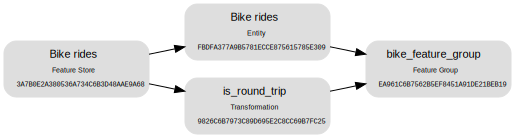

In [26]:
feature_group_bike.show()

<a id="create_dataset"></a>
### 3.4 Create dataset
A dataset is a collection of feature snapshots that are joined together to either train a model or perform model inference.

In [27]:
query.to_string()

'SELECT fg_0.tripduration tripduration, fg_0.starttime starttime, fg_0.stoptime stoptime, fg_0.startstationid startstationid, fg_0.startstationname startstationname, fg_0.startstationlatitude startstationlatitude, fg_0.startstationlongitude startstationlongitude, fg_0.endstationid endstationid, fg_0.endstationname endstationname, fg_0.endstationlatitude endstationlatitude, fg_0.endstationlongitude endstationlongitude, fg_0.bikeid bikeid, fg_0.usertype usertype, fg_0.birthyear birthyear, fg_0.gender gender, fg_0.roundtrip roundtrip FROM `FBDFA377A9B5781ECCE875615785E309`.bike_feature_group fg_0'

In [28]:
dataset_resource = (
    Dataset()
    .with_description("Dataset consisting of a subset of features in feature group: bike riders")
    .with_compartment_id(compartment_id)
    .with_name("bike_riders_dataset")
    .with_entity_id(entity.id)
    .with_feature_store_id(feature_store.id)
    .with_query(query.to_string())
)

In [29]:
dataset = dataset_resource.create()

You can call the `materialise()` method of the Dataset instance to load the data to dataset.

In [30]:
dataset.materialise()


distutils Version classes are deprecated. Use packaging.version instead.



distutils Version classes are deprecated. Use packaging.version instead.





The 'warn' method is deprecated, use 'warning' instead


INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ C8260DD6D1F753B0208459817B81E804 │    DATASET    │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


<a id="explore_dataset"></a>
### 3.5 Explore dataset

In [31]:
dataset.as_of(version_number=0).show()

+------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+------+----------+---------+------+---------+
|tripduration|           starttime|            stoptime|startstationid|    startstationname|startstationlatitude|startstationlongitude|endstationid|      endstationname|endstationlatitude|endstationlongitude|bikeid|  usertype|birthyear|gender|roundtrip|
+------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+------+----------+---------+------+---------+
|         320|2019-01-01 00:01:...|2019-01-01 00:07:...|        3160.0|Central Park West...|         40.77896784|         -73.97374737|      3283.0|W 89 St & Columbu...|        40.7882213|       -73.97041561| 15839|Subscriber|     1971|  

In [32]:
dataset.get_statistics().to_pandas()

tripduration  \
Skewness                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             {'metric_name': 'Skewness', 'metric_description': 'Feature Metric to compute Skewness', 'variable_count': 1, 'variable_names': ['skewness'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [183.69828103920275], 'metadata': {}}   
StandardDeviation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'metric_name': 'StandardDeviation', 'metric_description': 'Feature Metric to compute Standard Deviation', 'variable_count': 1, 'variable_names': ['standard_deviation'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [7144.810736129409], 'metadata': {}}   
Min                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     {'metric_name': 'Min', 'metric_description': 'Feature Metric to compute minimum value', 'variable_count': 1, 'variable_names': ['min'], 'variable_types': ['CONTINUOUS'], 'variable_dtypes': ['FLOAT'], 'variable_dimensions': [0], 'metric_data': [61.0], 'metadata': {}}   
IsConstantFeature                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         {'metric_name': 'IsConstantFeature', 'metric_description': 'Feature Metric to compute if all values are same', 'variable_count': 1, 'variable_names': ['is_constant'], 'variable_types': ['BINARY'], 'variable_dtypes': ['BOOLEAN'], 'variable_dimensions': [0], 'metric_data': [False], 'metadata': {}}   
IQR                                                                                                                                                                                                                                                                                                                                                                         {'metric_name': 'IQR', 'metric_description': 'Compute the interquartile range of the data. Interquartile range (IQR) is the difference between the 75th and 25th percentile of the data. It is a measure of 


distutils Version classes are deprecated. Use packaging.version instead.




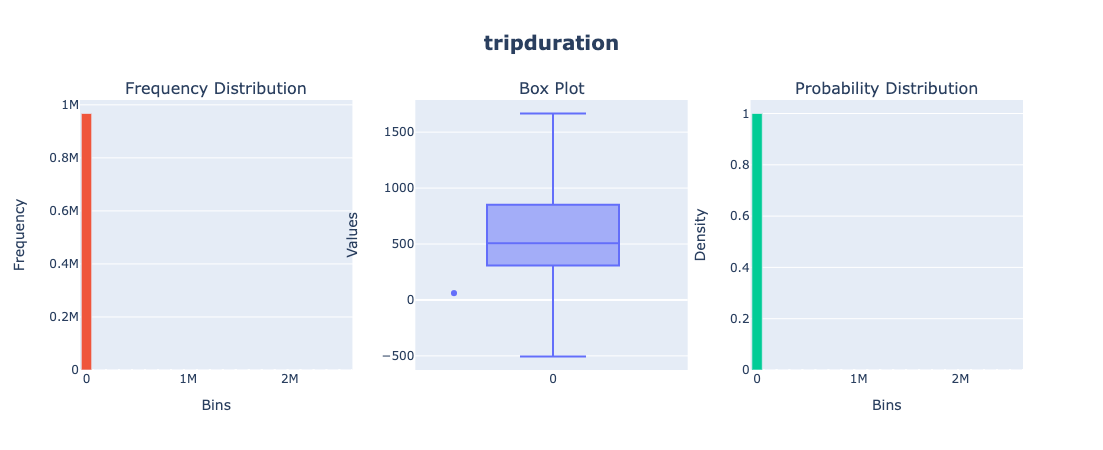

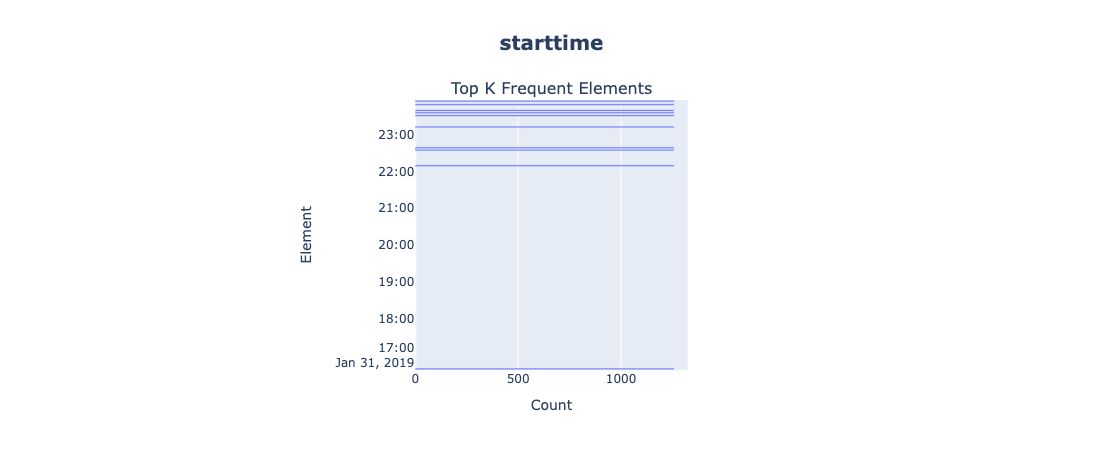

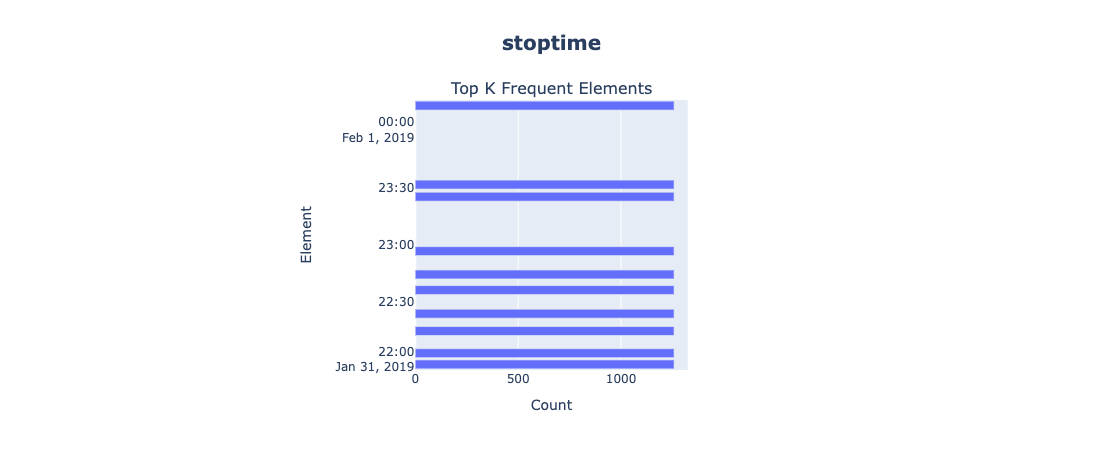

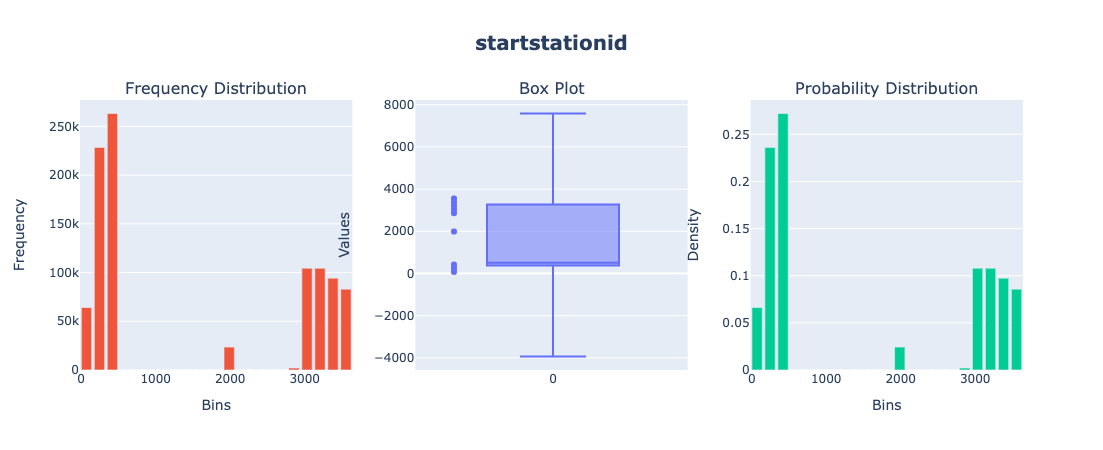

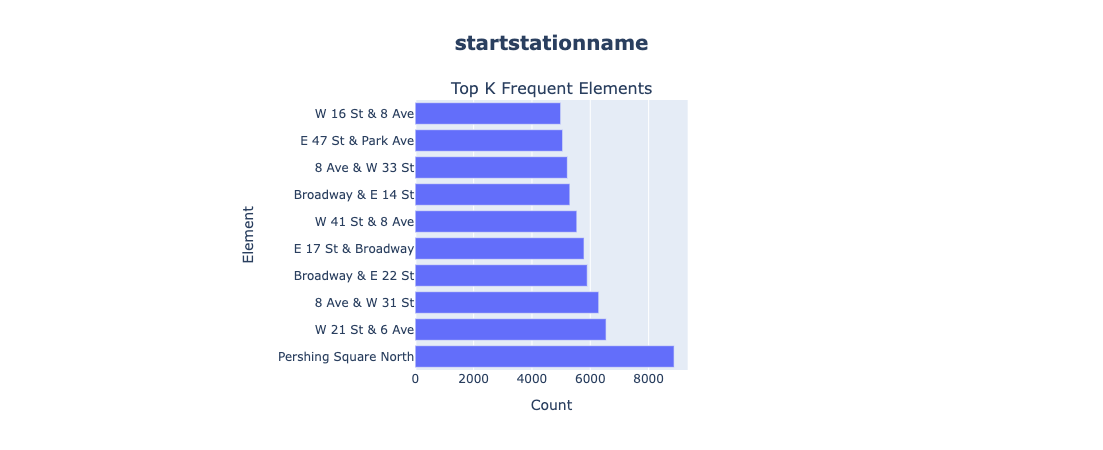

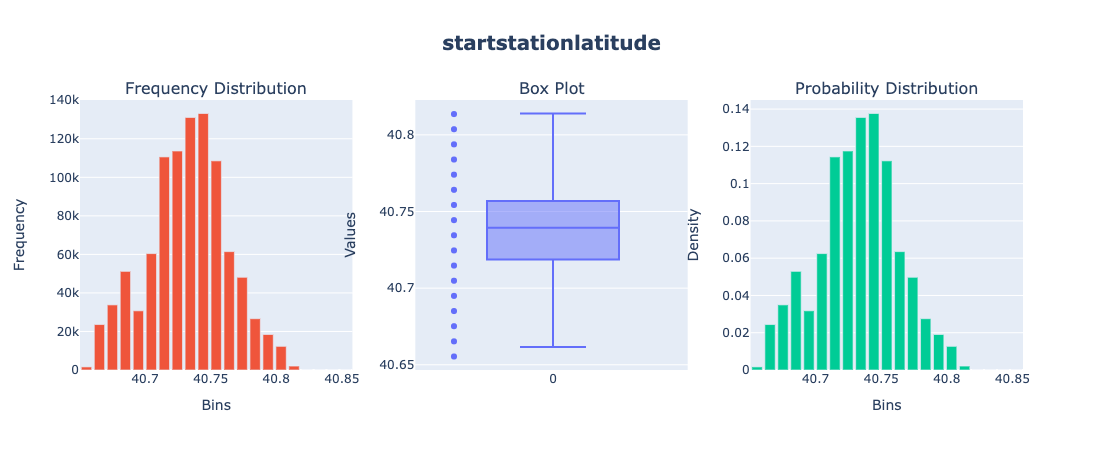

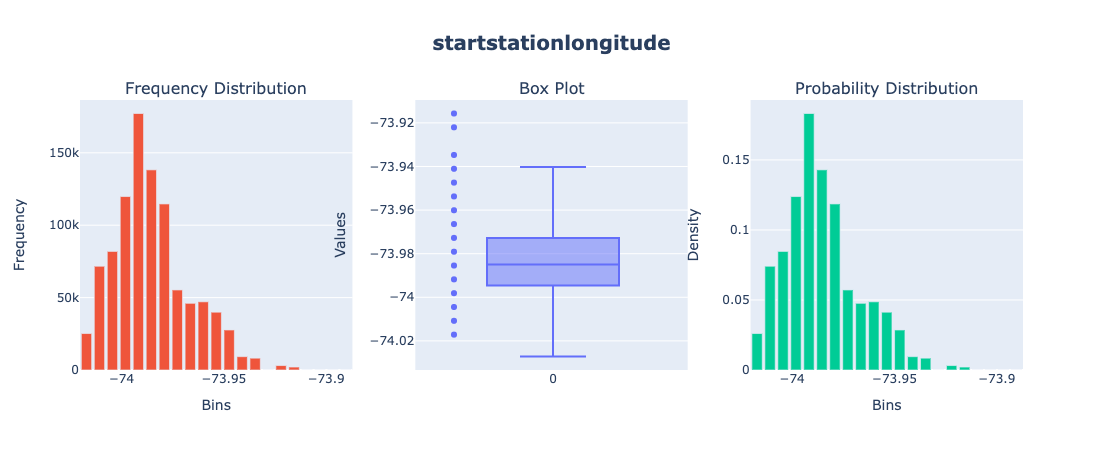

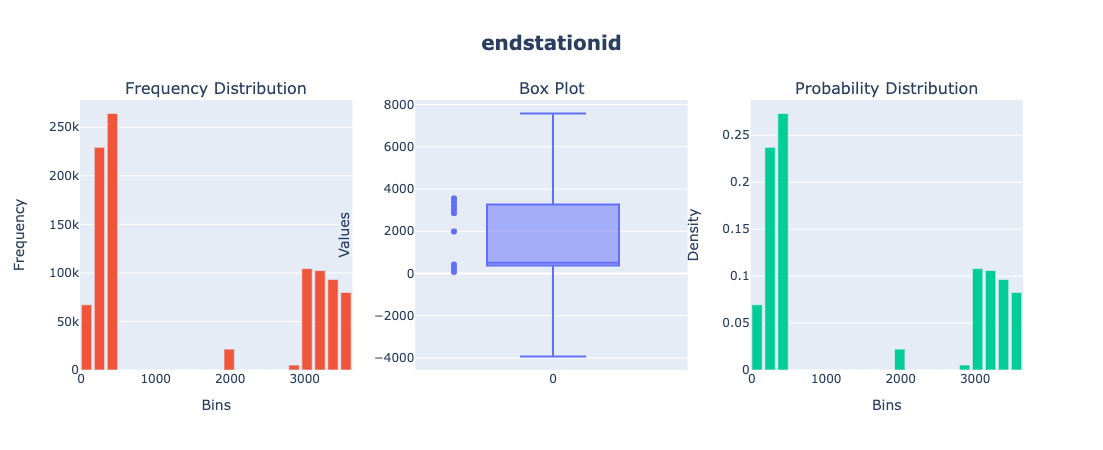

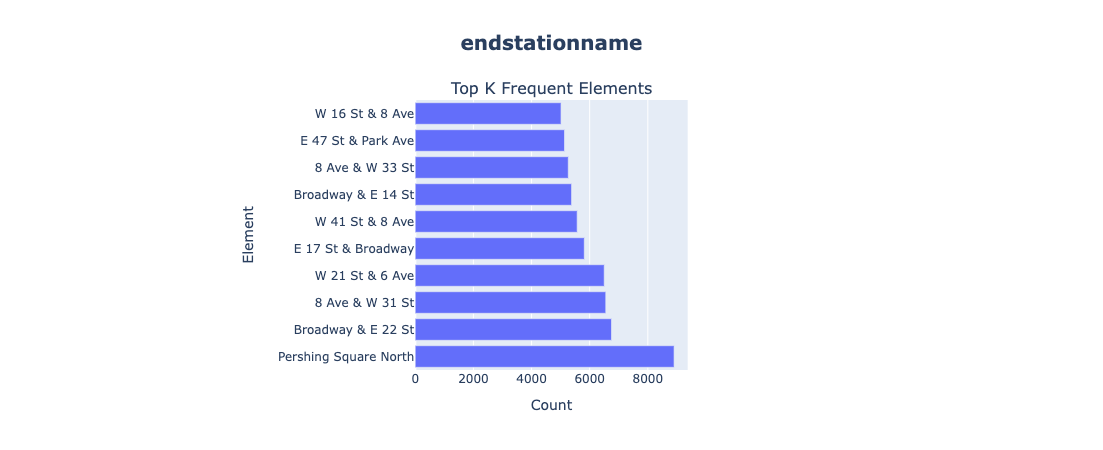

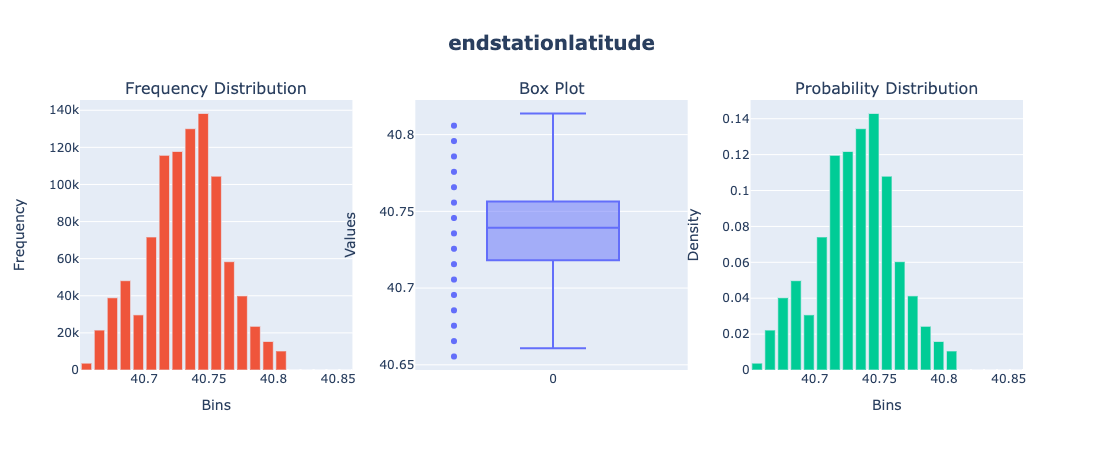

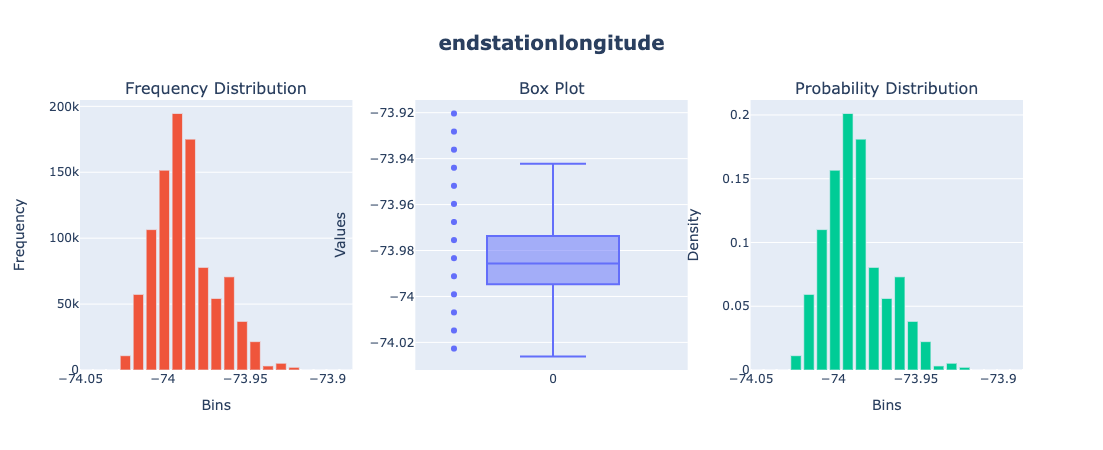

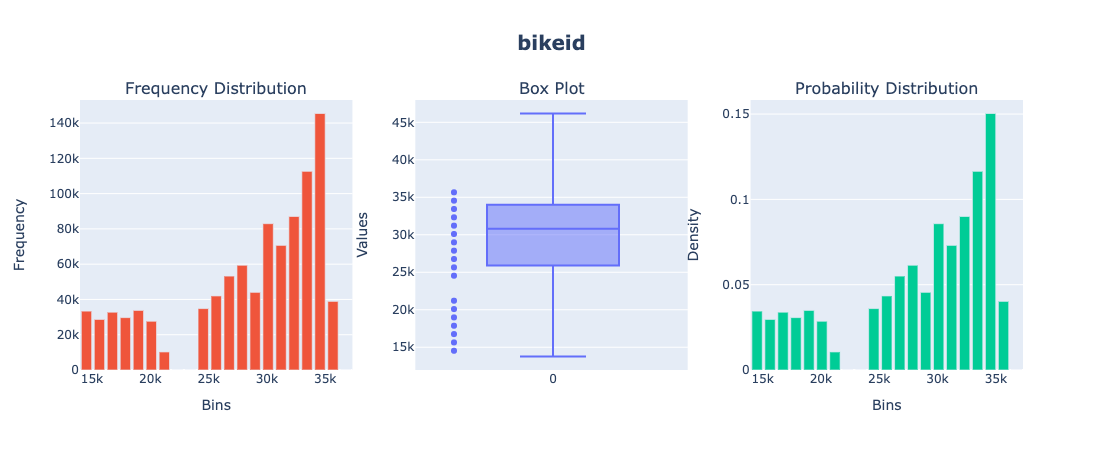

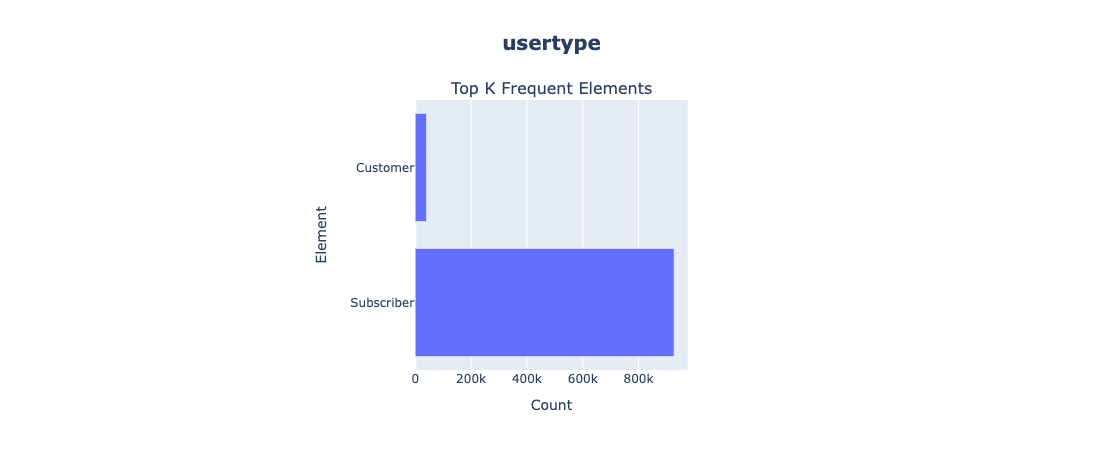

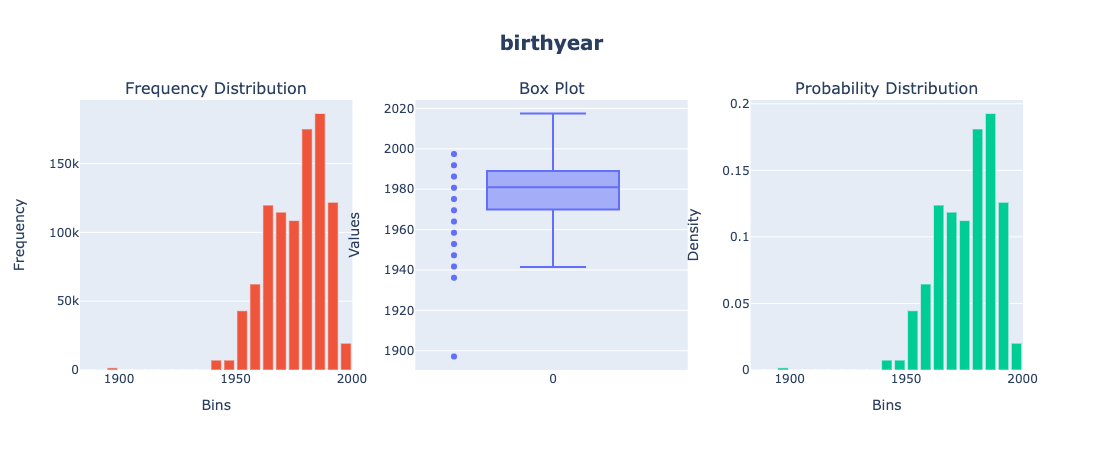

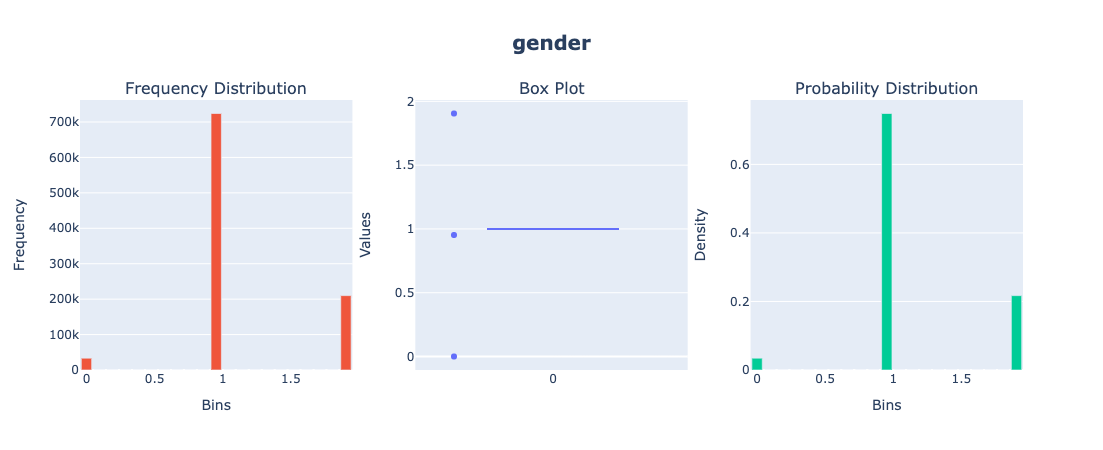

No statistical information for feature roundtrip can be visualised


In [33]:
dataset.get_statistics().to_viz()

In [34]:
dataset.profile().show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+
|format|                  id|                name|description|            location|           createdAt|       lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+
| delta|a9159aab-a1bb-433...|fbdfa377a9b5781ec...|       null|oci://MetaStore-M...|2023-12-11 07:50:...|2023-12-11 07:50:58|              []|       2|   30178419|        {}|               1|               2|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+------

<a id="visualise_lineage"></a>
#### Visualise lineage

Use the ```.show()``` method on the Dataset instance to visualize the lineage of the dataset.

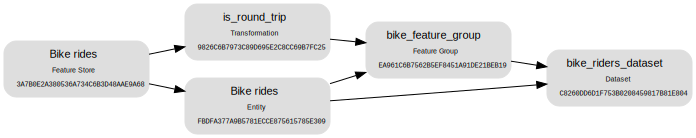

In [35]:
dataset.show()

<a id="featurestore_yaml"></a>
# 4. Feature store quickstart using YAML
In an ADS feature store module, you can either use the Python programmatic interface or YAML to define feature store entities. Below section describes how to create feature store entities using YAML as an interface.

In [38]:
feature_store_yaml = f"""
apiVersion: v1
kind: featureStore
spec:
  displayName: Bike feature store
  compartmentId: "{compartment_id}"
  offlineConfig:
    metastoreId: "{metastore_id}"

  entity: &bike_entity
    - kind: entity
      spec:
        name: Bike rides

  featureGroup:
    - kind: featureGroup
      spec:
        entity: *bike_entity
        name: bike_feature_group
        primaryKeys:
          - bikeid
        inputFeatureDetails:
          - name: "bikeid"
            featureType: "INTEGER"
            orderNumber: 1
            cast: "STRING"
          - name: "endstationlongitude"
            featureType: "FLOAT"
            orderNumber: 2
            cast: "STRING"
          - name: "tripduration"
            featureType: "INTEGER"
            orderNumber: 3
            cast: "STRING"

  dataset:
    - kind: dataset
      spec:
        name: bike_dataset
        entity: *bike_entity
        description: "Dataset for bike"
        query: 'SELECT bike.bikeid, bike.endstationlongitude FROM bike_feature_group bike'
"""

In [39]:
registrar = FeatureStoreRegistrar.from_yaml(yaml_string=feature_store_yaml)
registrar.create()

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

Successfully created 1 entities, 0 transformations, 1 feature groups and 1 datasets


(
 kind: featurestore
 spec:
   compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
   dataset:
   - kind: dataset
     spec:
       description: Dataset for bike
       entity: &id001
       - kind: entity
         spec:
           name: Bike rides
       name: bike_dataset
       query: SELECT bike.bikeid, bike.endstationlongitude FROM bike_feature_group
         bike
   displayName: Bike feature store
   entity: *id001
   featureGroup:
   - kind: featureGroup
     spec:
       entity: *id001
       inputFeatureDetails:
       - cast: STRING
         featureType: INTEGER
         name: bikeid
         orderNumber: 1
       - cast: STRING
         featureType: FLOAT
         name: endstationlongitude
         orderNumber: 2
       - cast: STRING
         featureType: INTEGER
         name: tripduration
         orderNumber: 3
       name: bike_feature_group
       primaryKeys:
       - bikeid
   id: 81A4FBBB6A8D9B1AF5F4644D6758E9EE
   offline

<a id='ref'></a>
# References

- [Feature Store Documentation](https://feature-store-accelerated-data-science.readthedocs.io/en/latest/overview.html)
- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)